<a href="https://colab.research.google.com/github/herbiebradley/CycleGAN-Tensorflow/blob/master/notebooks/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()

import os
import time
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display

In [0]:
# Test how much GPU RAM on Google Colab
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

### Define Hyperparameters

In [0]:
learning_rate = 0.0002
batch_size = 1 # Set batch size to 4 or 16 if training multigpu
img_size = 256
cyc_lambda = 10
epochs = 1

### Load Datasets

In [3]:
path_to_zip = tf.keras.utils.get_file('horse2zebra.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip', 
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'horse2zebra/')

116875264/116867962 [==============================] - 6s 0us/step


In [4]:
trainA_path = os.path.join(PATH, "trainA")
trainB_path = os.path.join(PATH, "trainB")

trainA_size = len(os.listdir(trainA_path))
trainB_size = len(os.listdir(trainB_path))
print(trainA_size)
print(trainB_size)

1067
1334


In [0]:
def load_image(image_file):
    image = tf.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, [256, 256])
    image = (image / 127.5) - 1
    return image

In [0]:
train_datasetA = tf.data.Dataset.list_files(PATH+'trainA/*.jpg', shuffle=False)
train_datasetA = train_datasetA.shuffle(trainA_size).repeat(epochs)
train_datasetA = train_datasetA.map(lambda x: load_image(x))
train_datasetA = train_datasetA.batch(batch_size)
train_datasetA = train_datasetA.prefetch(batch_size)
train_datasetA = iter(train_datasetA)

train_datasetB = tf.data.Dataset.list_files(PATH+'trainB/*.jpg', shuffle=False)
train_datasetB = train_datasetB.shuffle(trainB_size).repeat(epochs)
train_datasetB = train_datasetB.map(lambda x: load_image(x))
train_datasetB = train_datasetB.batch(batch_size)
train_datasetB = train_datasetB.prefetch(batch_size)
train_datasetB = iter(train_datasetB)

### Define CycleGAN architecture

In [0]:
class Encoder(tf.keras.Model):
  
    def __init__(self):
        super(Encoder, self).__init__()
    
        # Small variance in initialization helps with preventing colour inversion.
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=7, strides=1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv3 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
    
    def call(self, inputs, training=True):
    
        x = tf.pad(inputs, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
    
        x = self.conv1(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        # Implement instance norm to more closely match orig. paper (momentum=0.1)?
        x = tf.nn.relu(x)
    
        x = self.conv2(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = tf.nn.relu(x)
    
        x = self.conv3(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = tf.nn.relu(x)
    
        return x
  
  
class Residual(tf.keras.Model):
  
    def __init__(self):
        super(Residual, self).__init__()
    
        self.conv1 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
    
    def call(self, inputs, training=True):
    
        x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    
        x = self.conv1(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = tf.nn.relu(x)
    
        x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    
        x = self.conv2(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
    
        x = tf.add(x, inputs)

        return x

    
class Decoder(tf.keras.Model):
  
    def __init__(self):
        super(Decoder, self).__init__()
    
        self.conv1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv3 = tf.keras.layers.Conv2D(3, kernel_size=7, strides=1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
    
    def call(self, inputs, training=True):
    
        x = self.conv1(inputs)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = tf.nn.relu(x)
    
        x = tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        
        x = self.conv3(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = tf.nn.tanh(x)
    
        return x
  
  
class Generator(tf.keras.Model):

    def __init__(self, img_size=256, skip=False):
        super(Generator, self).__init__()
    
        self.img_size = img_size
        self.skip = skip #TODO: Add skip
    
        self.encoder = Encoder()
        if(img_size == 128):
            self.res1 = Residual()
            self.res2 = Residual()
            self.res3 = Residual()
            self.res4 = Residual()
            self.res5 = Residual()
            self.res6 = Residual()
        else:
            self.res1 = Residual()
            self.res2 = Residual()
            self.res3 = Residual()
            self.res4 = Residual()
            self.res5 = Residual()
            self.res6 = Residual()
            self.res7 = Residual()
            self.res8 = Residual()
            self.res9 = Residual()
        self.decoder = Decoder()
  
    @tf.contrib.eager.defun
    def call(self, inputs, training=True):
    
        x = self.encoder(inputs, training)
        if(img_size == 128):
            x = self.res1(x, training)
            x = self.res2(x, training)
            x = self.res3(x, training)
            x = self.res4(x, training)
            x = self.res5(x, training)
            x = self.res6(x, training)
        else:
            x = self.res1(x, training)
            x = self.res2(x, training)
            x = self.res3(x, training)
            x = self.res4(x, training)
            x = self.res5(x, training)
            x = self.res6(x, training)
            x = self.res7(x, training)
            x = self.res8(x, training)
            x = self.res9(x, training)
        x = self.decoder(x, training)
      
        return x

In [0]:
class Discriminator(tf.keras.Model):
  
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv3 = tf.keras.layers.Conv2D(256, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv4 = tf.keras.layers.Conv2D(512, kernel_size=4, strides=1, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        self.conv5 = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same', kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
      
        self.leaky = tf.keras.layers.LeakyReLU(0.2)
  
    @tf.contrib.eager.defun
    def call(self, inputs, training=True):
    
        x = self.conv1(inputs)
        x = self.leaky(x)
    
        x = self.conv2(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = self.leaky(x)
    
        x = self.conv3(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = self.leaky(x)
    
        x = self.conv4(x)
        x = tf.contrib.layers.instance_norm(x, epsilon=1e-05, trainable=training)
        x = self.leaky(x)
    
        x = self.conv5(x)
        #x = tf.nn.sigmoid(x) # use_sigmoid = not lsgan
        return x

### Define Loss functions

In [0]:
def discriminator_loss(disc_of_real_output, disc_of_gen_output, lsgan=True):
  
    if lsgan: # Use least squares loss
        real_loss = tf.reduce_mean(tf.squared_difference(disc_of_real_output, 1))
        generated_loss = tf.reduce_mean(tf.square(disc_of_gen_output))
    
        total_disc_loss = (real_loss + generated_loss) * 0.5 # 0.5 slows down rate that D learns compared to G
    else: # Use vanilla GAN loss
        real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_of_real_output), logits = disc_of_real_output)
        generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_of_gen_output), logits = disc_of_gen_output)

        total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [0]:
def generator_loss(disc_of_gen_output, lsgan=True):
    if lsgan: # Use least squares loss
        gen_loss = tf.reduce_mean(tf.squared_difference(disc_of_gen_output, 1))
    else: # Use vanilla GAN loss
        gen_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output), logits = disc_generated_output) 
        #l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) # Look up pix2pix loss
    return gen_loss

In [0]:
def cycle_consistency_loss(data_A, data_B, reconstructed_data_A, reconstructed_data_B, cyc_lambda=10):
    loss = tf.reduce_mean(tf.abs(data_A - reconstructed_data_A) + tf.abs(data_B - reconstructed_data_B))
    return cyc_lambda * loss

In [0]:
discA = Discriminator()
discB = Discriminator()
genA2B = Generator()
genB2A = Generator()

In [0]:
discA_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
discB_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
genA2B_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
genB2A_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)

In [0]:
checkpoint_dir = '/content/gdrive/My Drive/Checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(discA=discA, discB=discB, genA2B=genA2B, genB2A=genB2A,
                                 discA_optimizer=discA_optimizer, discB_optimizer=discB_optimizer,
                                 genA2B_optimizer=genA2B_optimizer, genB2A_optimizer=genB2A_optimizer)

In [51]:
!ls

gdrive	horse2zebra  horse2zebra.zip  sample_data


In [0]:
def generate_images(fake_A, fake_B):
    plt.figure(figsize=(15,15))
    fake_A = tf.reshape(fake_A, [256, 256, 3])
    fake_B = tf.reshape(fake_B, [256, 256, 3])
    display_list = [fake_A, fake_B]
    title = ['Generated A', 'Generated B']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [0]:
def train(train_datasetA, train_datasetB, epochs, lsgan=True, cyc_lambda=10):  
    for epoch in range(epochs):
        start = time.time()

        for i in range(1000):

            with tf.GradientTape() as genA2B_tape, tf.GradientTape() as genB2A_tape, \
                 tf.GradientTape() as discA_tape, tf.GradientTape() as discB_tape:
                try:
                    # Next training minibatches, default size 1
                    trainA = next(train_datasetA)
                    trainB = next(train_datasetB)
                except tf.errors.OutOfRangeError:
                    print("Error, run out of data")
                    break
        
                genA2B_output = genA2B(trainA, training=True)
                genB2A_output = genB2A(trainB, training=True)
        
                generate_images(genB2A_output, genA2B_output)
        
                discA_real_output = discA(trainA, training=True)
                discB_real_output = discB(trainB, training=True)
        
                discA_fake_output = discA(genB2A_output, training=True)
                discB_fake_output = discB(genA2B_output, training=True)
        
                reconstructedA = genB2A(genA2B_output, training=True)
                reconstructedB = genA2B(genB2A_output, training=True)
            
                #generate_images(reconstructedA, reconstructedB)
        
                # Use history buffer of 50 for disc loss
                discA_loss = discriminator_loss(discA_real_output, discA_fake_output, lsgan=lsgan)
                discB_loss = discriminator_loss(discB_real_output, discB_fake_output, lsgan=lsgan)

                genA2B_loss = generator_loss(discB_fake_output, lsgan=lsgan) + \
                          cycle_consistency_loss(trainA, trainB, reconstructedA, reconstructedB, cyc_lambda=cyc_lambda)
                genB2A_loss = generator_loss(discA_fake_output, lsgan=lsgan) + \
                          cycle_consistency_loss(trainA, trainB, reconstructedA, reconstructedB, cyc_lambda=cyc_lambda)

            genA2B_gradients = genA2B_tape.gradient(genA2B_loss, genA2B.variables)
            genB2A_gradients = genB2A_tape.gradient(genB2A_loss, genB2A.variables)
      
            discA_gradients = discA_tape.gradient(discA_loss, discA.variables)
            discB_gradients = discB_tape.gradient(discB_loss, discB.variables)

            genA2B_optimizer.apply_gradients(zip(genA2B_gradients, genA2B.variables))
            genB2A_optimizer.apply_gradients(zip(genB2A_gradients, genB2A.variables))
      
            discA_optimizer.apply_gradients(zip(discA_gradients, discA.variables))
            discB_optimizer.apply_gradients(zip(discB_gradients, discB.variables))
      
            print(i)
            display.clear_output(wait=True)
            if (i+1) % 100 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)
                print("Checkpoint saved at ", checkpoint_prefix)


        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

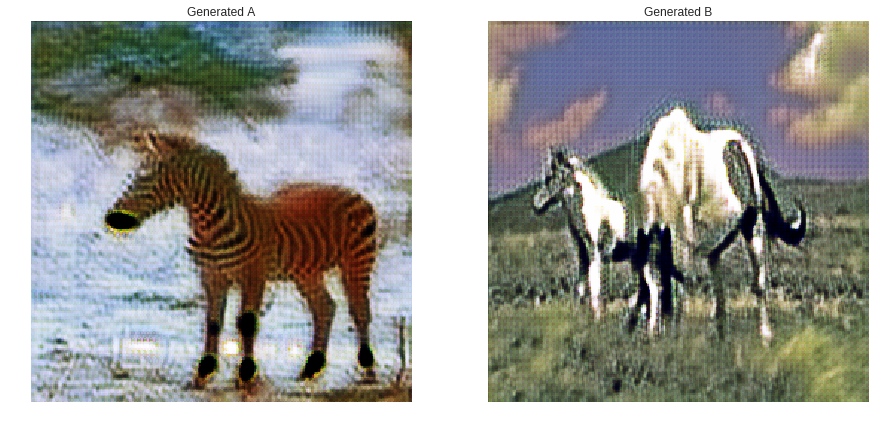

KeyboardInterrupt: ignored

In [22]:
train(train_datasetA, train_datasetB, epochs=1, lsgan=True, cyc_lambda=cyc_lambda)

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))